**Time Series Analysis of NVIDIA**
1. Loading and inspecting
2. Cleaning and preprocessing
3. Identifying patterns, trends, and anomalies
4. Visualizing distributions and relationships
5. Generating hypotheses for further modeling

Loading, importing tools and packages

In [2]:
!pip install yfinance fredapi

In [3]:
from fredapi import Fred  
fred = Fred(api_key='52929bbd4ee22a5af1226f97e0c8f356 ')  
interest_rates = fred.get_series('FEDFUNDS')  

In [4]:
import pandas as pd
import numpy as np 
import matplotlib as matlib
import seaborn as sb
import plotly as plt

In [5]:
file_path = "Nvidia_stock_data.csv"
nvidia_data = pd.read_csv(file_path)

print(nvidia_data.head())
print(interest_rates.head())

         Date     Close      High       Low      Open      Volume
0  1999-01-22  0.037612  0.044775  0.035581  0.040119  2714688000
1  1999-01-25  0.041552  0.042029  0.037612  0.040597   510480000
2  1999-01-26  0.038328  0.042865  0.037731  0.042029   343200000
3  1999-01-27  0.038209  0.039403  0.036298  0.038447   244368000
4  1999-01-28  0.038089  0.038447  0.037850  0.038209   227520000
1954-07-01    0.80
1954-08-01    1.22
1954-09-01    1.07
1954-10-01    0.85
1954-11-01    0.83
dtype: float64


Match the date-time of both datasets

In [6]:
# Step 1: Make sure 'Date' is a datetime column
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])

# Step 2: Set 'Date' as the index
nvidia_data.set_index('Date', inplace=True)

# Now check the index
print(nvidia_data.index)

DatetimeIndex(['1999-01-22', '1999-01-25', '1999-01-26', '1999-01-27',
               '1999-01-28', '1999-01-29', '1999-02-01', '1999-02-02',
               '1999-02-03', '1999-02-04',
               ...
               '2025-05-28', '2025-05-29', '2025-05-30', '2025-06-02',
               '2025-06-03', '2025-06-04', '2025-06-05', '2025-06-06',
               '2025-06-09', '2025-06-10'],
              dtype='datetime64[ns]', name='Date', length=6637, freq=None)


In [7]:
# Resample to daily frequency
nvidia_daily = nvidia_data.asfreq('D')  # This will now work as expected

# For interest rates, assuming already has datetime index
interest_daily = interest_rates.asfreq('D', method='ffill')
print(nvidia_daily.head())
print(interest_daily.head())

               Close      High       Low      Open        Volume
Date                                                            
1999-01-22  0.037612  0.044775  0.035581  0.040119  2.714688e+09
1999-01-23       NaN       NaN       NaN       NaN           NaN
1999-01-24       NaN       NaN       NaN       NaN           NaN
1999-01-25  0.041552  0.042029  0.037612  0.040597  5.104800e+08
1999-01-26  0.038328  0.042865  0.037731  0.042029  3.432000e+08
1954-07-01    0.8
1954-07-02    0.8
1954-07-03    0.8
1954-07-04    0.8
1954-07-05    0.8
Freq: D, dtype: float64


Fixing null values and scaling/normalization

In [8]:
# Drop rows where all columns are NaN (e.g., weekends/holidays)
nvidia_cleaned = nvidia_daily.dropna(how='all')

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Assume merged_df contains both NVDA Close and Interest Rate
merged_df = pd.DataFrame({
    'NVDA_Close': nvidia_cleaned['Close'],
    'Interest_Rate': interest_daily
})

# Drop any remaining NaNs before scaling
merged_df.dropna(inplace=True)

# Apply scaling
scaled_values = scaler.fit_transform(merged_df)
scaled_df = pd.DataFrame(scaled_values, columns=merged_df.columns, index=merged_df.index)

In [10]:
scaled_df.head(5)

,NVDA_Close,Interest_Rate
1999-01-22,0.000042,0.705701
1999-01-25,0.000069,0.705701
1999-01-26,0.000047,0.705701
1999-01-27,0.000046,0.705701
1999-01-28,0.000046,0.705701


Align to certain date range

In [11]:
# Example: Aligning three time series
final_df = pd.DataFrame({
    'NVDA_Close': nvidia_daily['Close'],
    'Interest_Rate': interest_daily,
    # Add other variables like semiconductor index or sentiment here
})

# Drop rows with any missing values across columns
final_df.dropna(inplace=True)

# Optional: Limit to a specific date range
start_date = '2020-01-01'
end_date = '2025-06-22'
final_df = final_df.loc[start_date:end_date]

In [12]:
print(final_df)

            NVDA_Close  Interest_Rate
2020-01-02    5.972160           1.55
2020-01-03    5.876570           1.55
2020-01-06    5.901214           1.55
2020-01-07    5.972660           1.55
2020-01-08    5.983861           1.55
...                ...            ...
2025-04-25  111.010002           4.33
2025-04-28  108.730003           4.33
2025-04-29  109.019997           4.33
2025-04-30  108.919998           4.33
2025-05-01  111.610001           4.33

[1340 rows x 2 columns]


**Univariate Analysis**

Time Series Decomposition

Multiplicative


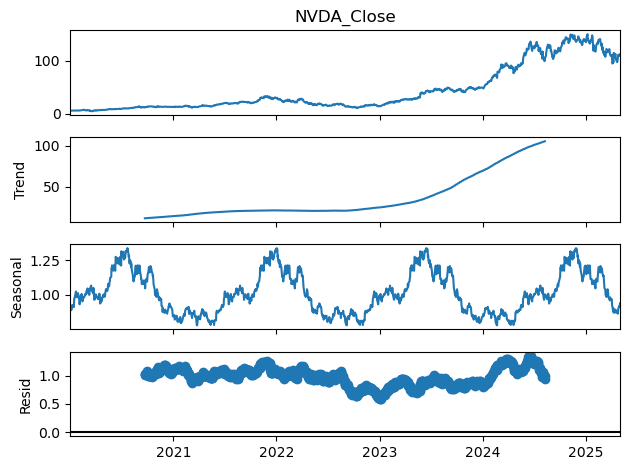

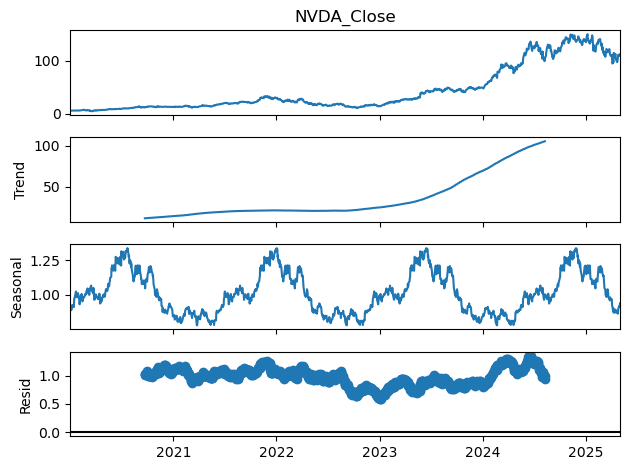

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
print("Multiplicative")
result = seasonal_decompose(final_df['NVDA_Close'], model='multiplicative', period=365)
result.plot()

Additive


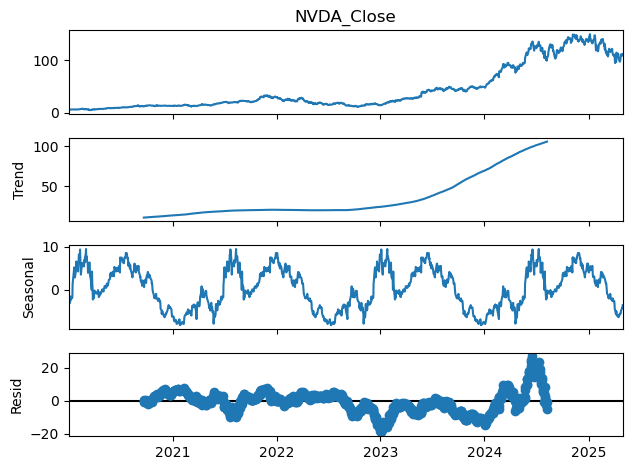

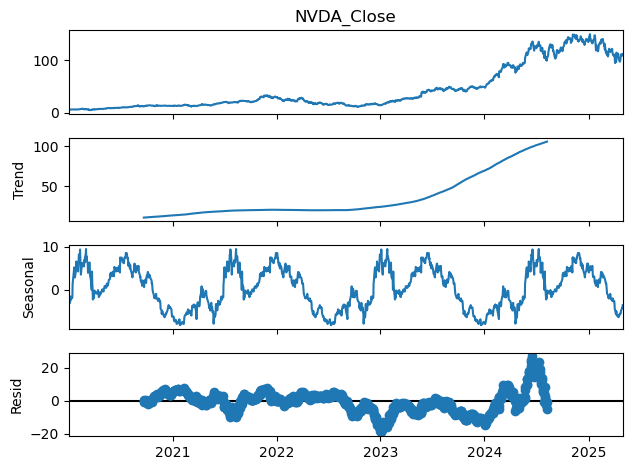

In [14]:
print("Additive")
result2 = seasonal_decompose(final_df['NVDA_Close'], model='additive', period=365)
result2.plot()

Smoothing Methods

<Axes: title={'center': 'Moving Average Smoothing'}>

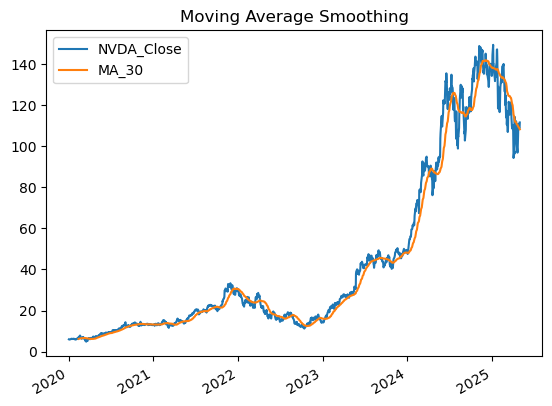

In [15]:
final_df['MA_30'] = final_df['NVDA_Close'].rolling(window=30).mean()
final_df[['NVDA_Close', 'MA_30']].plot(title="Moving Average Smoothing")

C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zshua\anaconda3\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: title={'center': 'Exponential Smoothing'}>

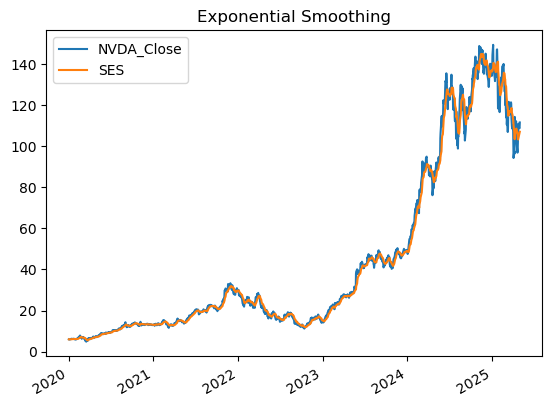

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(final_df['NVDA_Close'])
fit = model.fit(smoothing_level=0.2)
final_df['SES'] = fit.fittedvalues
final_df[['NVDA_Close', 'SES']].plot(title="Exponential Smoothing")

Stationary Check

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

adf_test(final_df['NVDA_Close'])

ADF Statistic: -0.17860742649194006
p-value: 0.9410239792279169
Critical Values:
   1%: -3.4353174541055567
   5%: -2.863733732389869
   10%: -2.5679379527245407


ADF Statistic: -7.823781224412655
p-value: 6.563629351940112e-12
Critical Values:
   1%: -3.4353174541055567
   5%: -2.863733732389869
   10%: -2.5679379527245407


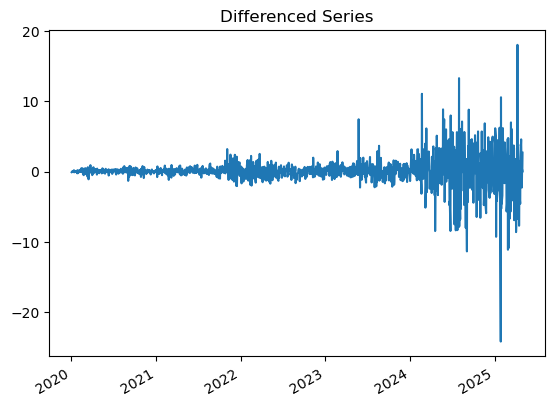

In [18]:
final_df['Close_diff'] = final_df['NVDA_Close'].diff()
final_df['Close_diff'].dropna().plot(title="Differenced Series")
adf_test(final_df['Close_diff'].dropna())

Autocorrelation (ACF & PACF)

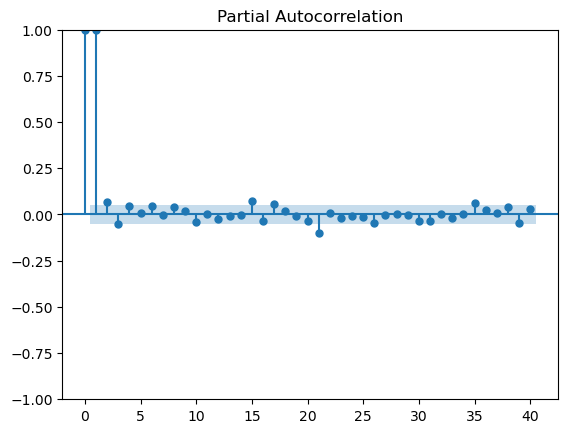

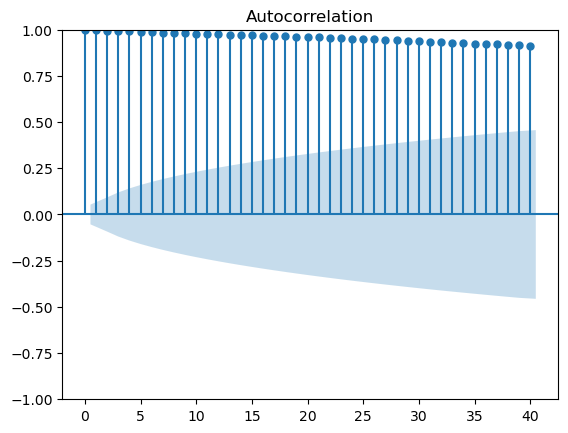

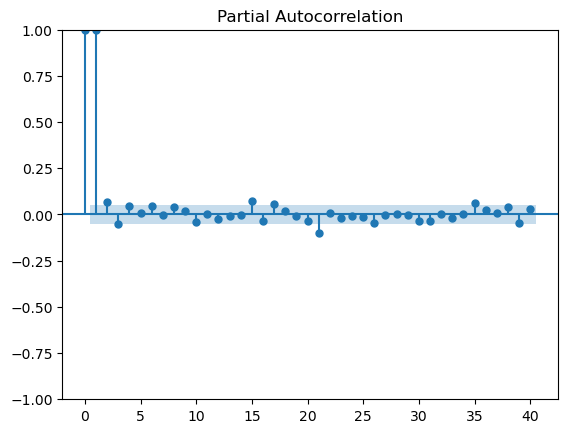

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(final_df['NVDA_Close'].dropna(), lags=40)
plot_pacf(final_df['NVDA_Close'].dropna(), lags=40)

ACF:
Positive and slowly decaying
Non-stationary / trending series
PACF:
Only first 2 lags significant
Suggests AR(2) process

**Bivariate Analysis**

  Correlation Analysis

In [20]:
corr = final_df[['NVDA_Close', 'Interest_Rate']].corr()
print("Correlation Matrix:\n", corr)

Correlation Matrix:
                NVDA_Close  Interest_Rate
NVDA_Close       1.000000       0.664229
Interest_Rate    0.664229       1.000000


<Axes: xlabel='Interest_Rate', ylabel='NVDA_Close'>

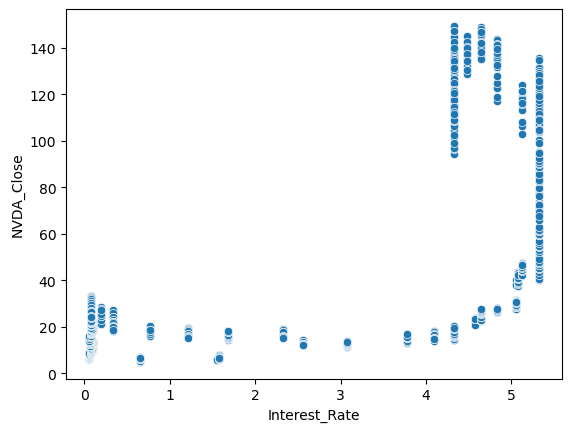

In [21]:
import seaborn as sns
sns.scatterplot(x='Interest_Rate', y='NVDA_Close', data=final_df)

Simple Linear Regression

In [22]:
import statsmodels.api as sm

X = sm.add_constant(final_df['Interest_Rate'])  # Adds intercept
y = final_df['NVDA_Close']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NVDA_Close   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     1056.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):          2.69e-171
Time:                        13:56:40   Log-Likelihood:                -6524.1
No. Observations:                1340   AIC:                         1.305e+04
Df Residuals:                    1338   BIC:                         1.306e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0673      1.295      9.319

Multiple Regression

In [23]:
X = final_df[['Interest_Rate']]
X = sm.add_constant(X)
y = final_df['NVDA_Close']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NVDA_Close   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     1056.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):          2.69e-171
Time:                        13:56:40   Log-Likelihood:                -6524.1
No. Observations:                1340   AIC:                         1.305e+04
Df Residuals:                    1338   BIC:                         1.306e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0673      1.295      9.319

R-squared
~44% of variance explained
Interest Rate Coefficient
+12.22 (unexpected positive sign)
Significance
Strongly significant (p < 0.001)
Autocorrelation
High (Durbin-Watson = 0.005)
Normality
Residuals not normally distributed

Time Series Regression (with Seasonality Removed)

In [24]:
# Regress detrended/deseasonalized variable
X = sm.add_constant(final_df['Interest_Rate'])
y = final_df['Close_diff'].dropna()

# Make sure indices match
X = X.loc[y.index]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Close_diff   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.792
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.181
Time:                        13:56:40   Log-Likelihood:                -2915.2
No. Observations:                1339   AIC:                             5834.
Df Residuals:                    1337   BIC:                             5845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0089      0.088     -0.101

R-squared
~0.1% variance explained
Interest Rate Coefficient
+0.034 (not significant)
F-test Significance
p = 0.181 → Not significant
Autocorrelation
None detected
Normality
Residuals are not normally distributed

**Forecasting**

Preparing data

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Make sure final_df is sorted by date
final_df = final_df.sort_index()

# Split into train/test sets (e.g., use last 20% as test set)
train_size = int(len(final_df) * 0.8)
train, test = final_df.iloc[:train_size], final_df.iloc[train_size:]

In [26]:
!pip install statsmodels

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train['NVDA_Close'], order=(2,1,2))  # (p,d,q)
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))

C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model (no exogenous variables)
sarima_model = SARIMAX(train['NVDA_Close'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,365))  # yearly seasonality
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fit.get_forecast(steps=len(test))

C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zshua\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Create lagged features
def create_lagged_features(df, lags=5):
    df = df.copy()
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['NVDA_Close'].shift(lag)
    return df.dropna()

# Apply lagging
df_with_lags = create_lagged_features(final_df[['NVDA_Close', 'Interest_Rate']])

# Split again
train_xgb = df_with_lags.loc[train.index]
test_xgb = df_with_lags.loc[test.index]

# Define features and target
X_train = train_xgb.drop('NVDA_Close', axis=1)
y_train = train_xgb['NVDA_Close']
X_test = test_xgb.drop('NVDA_Close', axis=1)
y_test = test_xgb['NVDA_Close']

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict
xgb_forecast = xgb_model.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train[-100:]['NVDA_Close'], label='Train')
plt.plot(test['NVDA_Close'], label='Test')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast')
plt.plot(sarima_forecast.conf_int(), color='gray', alpha=0.3)
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.plot(sarimax_forecast.predicted_mean, label='SARIMAX Forecast')
plt.plot(xgb_forecast, label='XGBoost Forecast', linestyle='--')

plt.legend()
plt.title("Model Comparisons")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example: MAE of each model
mae_arima = mean_absolute_error(test['NVDA_Close'], arima_forecast)
mae_sarima = mean_absolute_error(test['NVDA_Close'], sarima_forecast.predicted_mean)
mae_sarimax = mean_absolute_error(test['NVDA_Close'], sarimax_forecast.predicted_mean)
mae_xgb = mean_absolute_error(y_test, xgb_forecast)

print(f"ARIMA MAE: {mae_arima:.4f}")
print(f"SARIMA MAE: {mae_sarima:.4f}")
print(f"SARIMAX MAE: {mae_sarimax:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")